**Objective**: In this notebook , we are going to be creating several machine learning models for the predictions of energy generating by a wind turbine system, given the weather conditions an hour prior

(TARGET COLMN is System power generated)

metrics: mean squared error and mean absolute error

**WORKFLOW**: In order to accomplish the above goal, we need to perform the following

1. Data Loading and Understanding
2. Cleaning the Data
3. Feature Engineering
4. Exploratory Data Analysis
5. Modelling
6. Hyperparameter Tuning
7. Model Selection
8. Inference Script Creation


DATA **LOADING**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in data
data = pd.read_csv("/content/TexasTurbine.csv")

In [4]:
# 10 rows
data.head(10)

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.640,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.830,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.230,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.590,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.280,9.184,150,0.998507,18.963
5,"Jan 1, 05:00 am",1293.930,8.996,149,0.998507,19.063
6,"Jan 1, 06:00 am",1301.630,9.016,151,0.998211,19.113
7,"Jan 1, 07:00 am",1308.130,9.036,154,0.997815,19.163
8,"Jan 1, 08:00 am",792.081,7.612,154,1.000280,19.363
9,"Jan 1, 09:00 am",399.537,6.129,162,1.002950,19.963


In [5]:
data.columns

Index(['Time stamp', 'System power generated | (kW)', 'Wind speed | (m/s)',
       'Wind direction | (deg)', 'Pressure | (atm)', 'Air temperature | ('C)'],
      dtype='object')

In [6]:
# getting the dimension of data
data.shape

(8760, 6)

**Cleaning The Data**

In [7]:
# check for missing values
data.isnull().sum()

,0
Time stamp,0
System power generated | (kW),0
Wind speed | (m/s),0
Wind direction | (deg),0
Pressure | (atm),0
Air temperature | ('C),0


In [8]:
# Fix the timestamp
data["Time stamp"] = pd.to_datetime(data["Time stamp"], format="%b %d, %I:%M %p", errors='coerce') # Remove the extra space after %I

# Convert the datetime objects back to strings before replacing
data["Time stamp"] = data["Time stamp"].dt.strftime("%Y-%m-%d %H:%M:%S").str.replace("1900", "2021")

In [9]:
# convert
data["Time stamp"] = pd.to_datetime(data["Time stamp"])

In [10]:
# how to see the timestamp
data.index = data["Time stamp"]

data.drop("Time stamp", axis=1, inplace=True)

In [11]:
data.head(10)

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
Time stamp,,,,,
2021-01-01 00:00:00,1766.640,9.926,128,1.000480,18.263
2021-01-01 01:00:00,1433.830,9.273,135,0.999790,18.363
2021-01-01 02:00:00,1167.230,8.660,142,0.999592,18.663
2021-01-01 03:00:00,1524.590,9.461,148,0.998309,18.763
2021-01-01 04:00:00,1384.280,9.184,150,0.998507,18.963
2021-01-01 05:00:00,1293.930,8.996,149,0.998507,19.063
2021-01-01 06:00:00,1301.630,9.016,151,0.998211,19.113
2021-01-01 07:00:00,1308.130,9.036,154,0.997815,19.163
2021-01-01 08:00:00,792.081,7.612,154,1.000280,19.363


In [12]:
# checking for duplicates
data.duplicated().sum()


0

**FEATURE ENGINEERING**

In [13]:
## Extract the following information from the date index: day of week,week the month, quarter and year



In [14]:
def extract_features(dataframe):

  """
  this function extracts data features from the index and also create a season columns
  """
  #copy dataframe
  dataframe = dataframe.copy()
  dataframe["quarter"] = dataframe.index.quarter
  dataframe["month"] = dataframe.index.month
  dataframe["week"] = dataframe.index.isocalendar().week.astype(int)
  dataframe["hour"] = dataframe.index.hour

  return dataframe

def map_month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'


In [15]:
data = extract_features(data)

In [16]:
data["season"] = data["month"].apply(map_month_to_season)

In [17]:
data

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C),quarter,month,week,hour,season
Time stamp,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,1234.70,8.848,129,0.998604,19.663,4,12,52,19,Winter
2021-12-31 20:00:00,1105.37,8.502,118,1.000090,19.063,4,12,52,20,Winter
2021-12-31 21:00:00,1405.71,9.224,117,0.998408,18.463,4,12,52,21,Winter


In [18]:
# view my data types
data.dtypes

,0
System power generated | (kW),float64
Wind speed | (m/s),float64
Wind direction | (deg),int64
Pressure | (atm),float64
Air temperature | ('C),float64
quarter,int32
month,int32
week,int64
hour,int32
season,object


In [19]:
data.columns

Index(['System power generated | (kW)', 'Wind speed | (m/s)',
       'Wind direction | (deg)', 'Pressure | (atm)', 'Air temperature | ('C)',
       'quarter', 'month', 'week', 'hour', 'season'],
      dtype='object')

In [20]:
data.columns = [ "power generated", 'Wind speed',
       'Wind dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season'] # Removed the trailing comma

In [21]:
data.head()

,power generated,Wind speed,Wind dir,Pressure,temperature,quarter,month,week,hour,season
Time stamp,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter


**EDA(UNIVARIATE)**

EXPLORATORY DATA ANALYSIS

In [22]:
# UNIVARIATE: POWER GENERATED ,WIND SPEED, DIRECTION, TEMPTERATURE, PRESURE AND SEASON
 # MULTIVARIATE

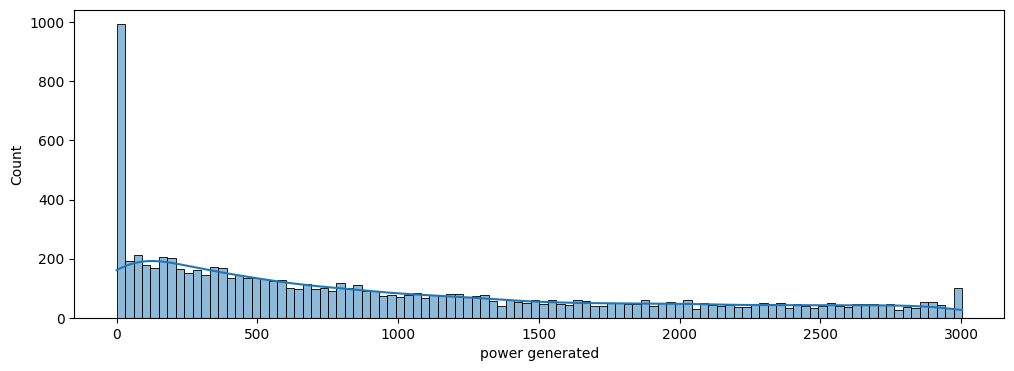

In [23]:
# Visualizing the distribution for power generated
plt.figure(figsize = (12,4))
# creating an histogram
sns.histplot(data["power generated"], bins = 100, kde = True)
plt.show()

In [24]:
#Rename the column with a space to use an underscore.
data.rename(columns={"power generated": "power_generated"}, inplace=True) # Remove the extra indentation (4 spaces)

In [25]:
data.power_generated.mean()

964.4679340166095

In [26]:
# statistics report on the columns
data.power_generated.describe()

,power_generated
count,8760.000000
mean,964.467934
std,878.558112
min,0.000000
25%,215.951500
50%,693.968500
75%,1562.287500
max,3004.010000


In [27]:
# selecting out null power generated rows
data[data["power_generated"]<=0]

# in 822 instances, we get power gen to be 0

,power_generated,Wind speed,Wind dir,Pressure,temperature,quarter,month,week,hour,season
Time stamp,,,,,,,,,,
2021-01-05 00:00:00,0.0,2.491,156,0.991694,20.263,1,1,1,0,Winter
2021-01-05 01:00:00,0.0,0.484,95,0.994162,19.963,1,1,1,1,Winter
2021-01-07 22:00:00,0.0,2.788,340,1.002560,10.863,1,1,1,22,Winter
2021-01-07 23:00:00,0.0,2.116,273,1.001870,11.963,1,1,1,23,Winter
2021-01-08 00:00:00,0.0,2.897,284,1.000980,12.063,1,1,1,0,Winter
...,...,...,...,...,...,...,...,...,...,...
2021-12-27 23:00:00,0.0,2.748,241,0.997129,13.863,4,12,52,23,Winter
2021-12-28 00:00:00,0.0,2.135,271,0.996338,14.163,4,12,52,0,Winter
2021-12-28 01:00:00,0.0,2.076,246,0.996338,14.163,4,12,52,1,Winter


In [28]:
## getting counts of season where power_gen is 0
data[data["power_generated"]<=0]["season"].value_counts()

,count
season,
Fall,284
Winter,239
Summer,191
Spring,108


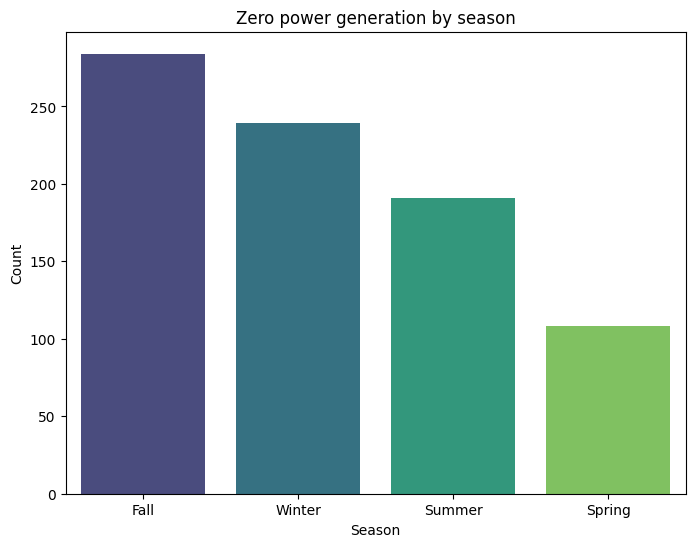

In [29]:
# barplot
season_counts = data[data["power_generated"]<=0]["season"].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x = season_counts.index, y=season_counts, palette = "viridis")
plt.title("Zero power generation by season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.show()

# Create a bar plot

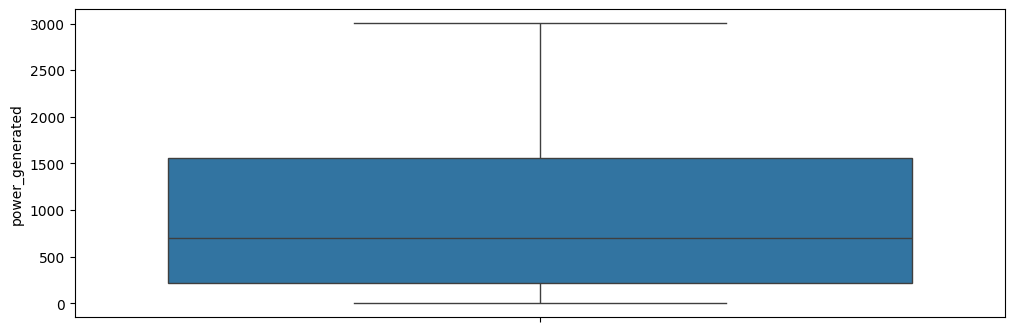

In [30]:
# checking for outlayers
plt.figure(figsize = (12,4))
# creating an boxplot
sns.boxplot(data["power_generated"])
plt.show()

## there is an absence of outliers in the power gen column

In [31]:
data.columns

Index(['power_generated', 'Wind speed', 'Wind dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season'],
      dtype='object')

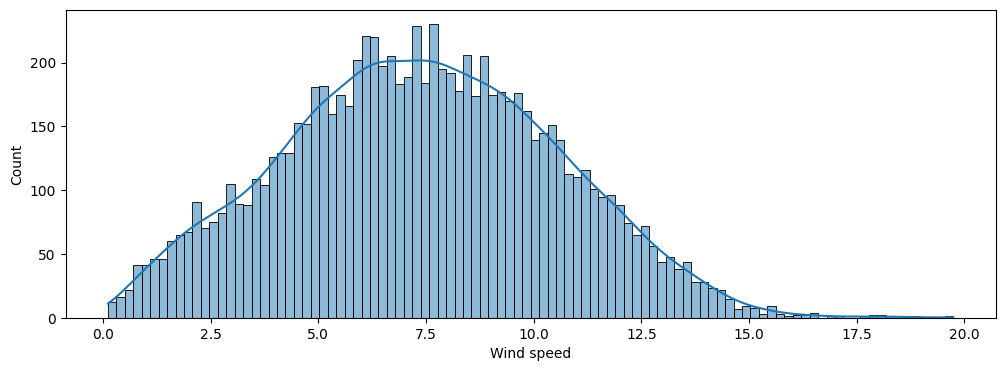

In [32]:
# checking for distribution of wind speed
plt.figure(figsize = (12,4))
# creating an histogram
sns.histplot(data["Wind speed"], bins = 100, kde = True)
plt.show()

wind speed is normally distributed

<Axes: ylabel='Wind speed'>

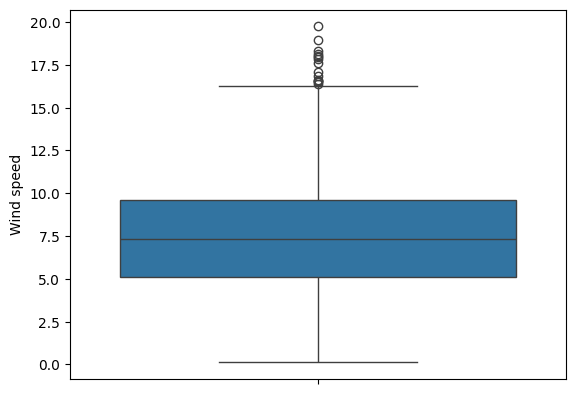

In [33]:
sns.boxplot(data["Wind speed"])

# sevirity is not too large

# you could remove outliers: by capping or transforming

<Axes: xlabel='Wind dir', ylabel='Count'>

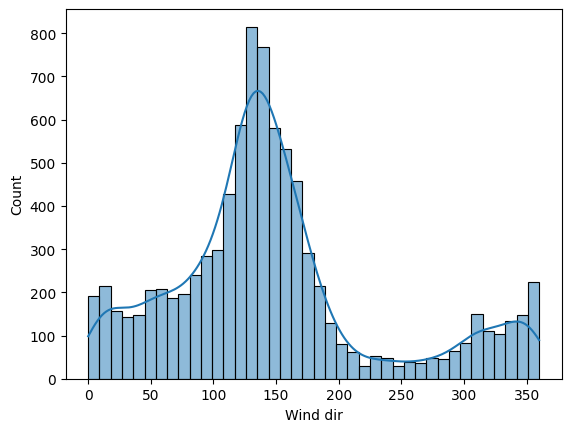

In [34]:
sns.histplot(data["Wind dir"], bins = 40, kde = True)

distribution of wind dir(in angles) is not strictly normal

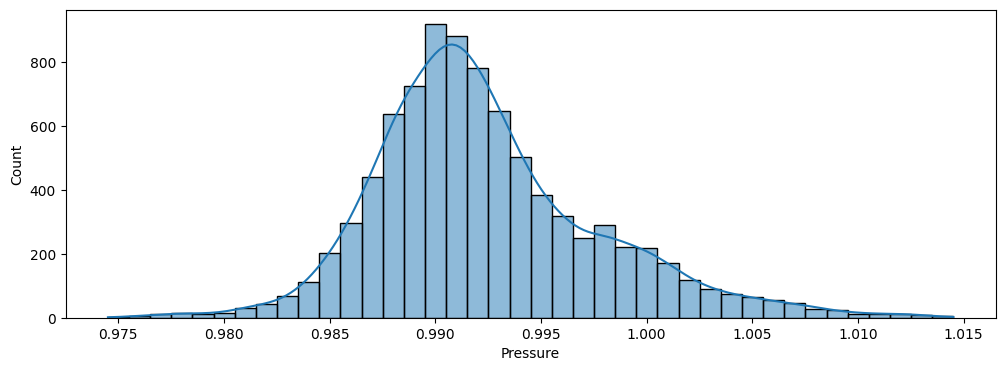

In [35]:
# showing the distribution of pressure values:
plt.figure(figsize = (12,4))
# creating an histogram
sns.histplot(data["Pressure"], bins = 40, kde = True)
plt.show()

In [36]:
data.columns

Index(['power_generated', 'Wind speed', 'Wind dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season'],
      dtype='object')

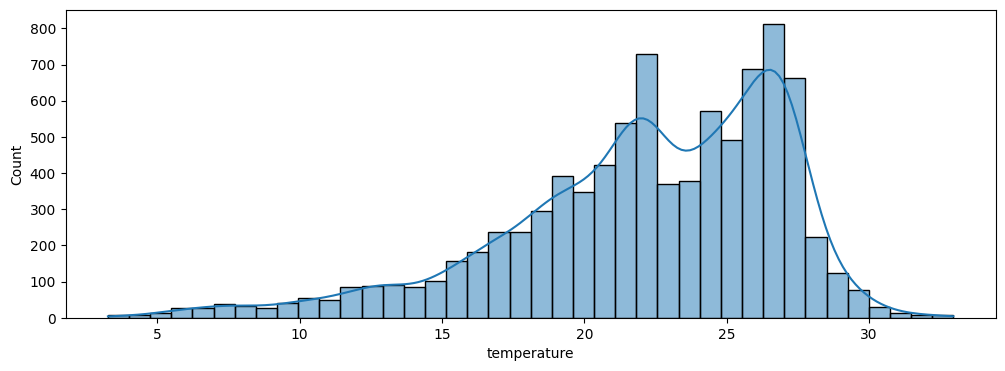

In [37]:
### showing the distribution of tempreture
plt.figure(figsize = (12,4))
# creating an histogram
sns.histplot(data["temperature"], bins = 40, kde = True)
plt.show()

temperatures is skwed to the right

**EDA (MULTIVARIATE)**

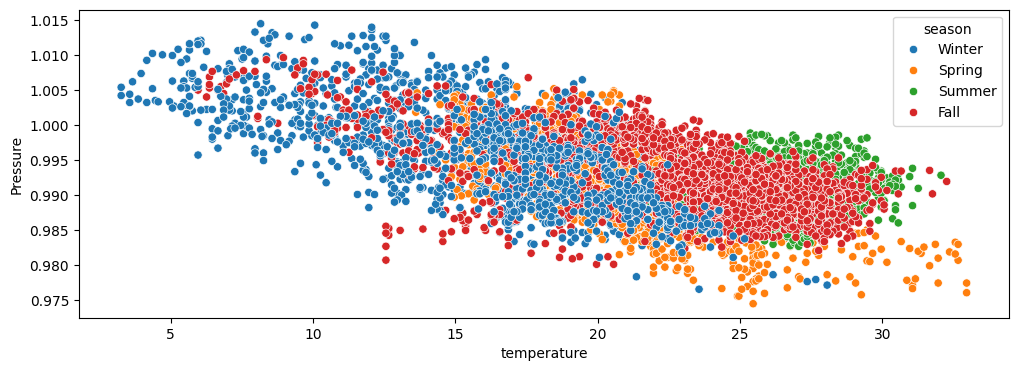

In [38]:
##Multivariate
#temperature vs pressure
plt.figure(figsize = (12,4))
sns.scatterplot(data = data, x = "temperature", y = "Pressure", hue = "season")
plt.show()

plt.show()

This scatter plot represents the relationship between temperature (x-axis) and pressure (y-axis) across different seasons, with data points coloured to indicate the season (Winter, Spring, Summer, and Fall). Here's an interpretation:

Seasonal Variation:

Winter (blue): The majority of data points cluster towards lower temperatures, with higher pressure. This aligns with colder, denser air during the winter season.
Spring (orange): Data points begin to shift toward mid-range temperatures, with some overlap with Winter and Fall data, but pressure starts decreasing slightly as temperature rises.
Summer (green): Higher temperatures dominate, with relatively low pressure. This reflects warmer conditions in summer and a general trend of lower atmospheric pressure at higher temperatures.
Fall (red): Temperature values overlap with both Summer and Winter, showing a transitional pattern. Pressure also spans a broader range compared to other seasons.
Temperature-Pressure Relationship:

There is a noticeable negative correlation: as temperature increases, pressure tends to decrease. This follows the basic principles of atmospheric behaviour, where warm air expands and reduces its density, leading to lower pressure.
Seasonal Overlaps:

While there are clear seasonal groupings, there’s significant overlap, particularly between Spring-Fall and Summer-Fall, which might reflect similar atmospheric conditions during transitional months.

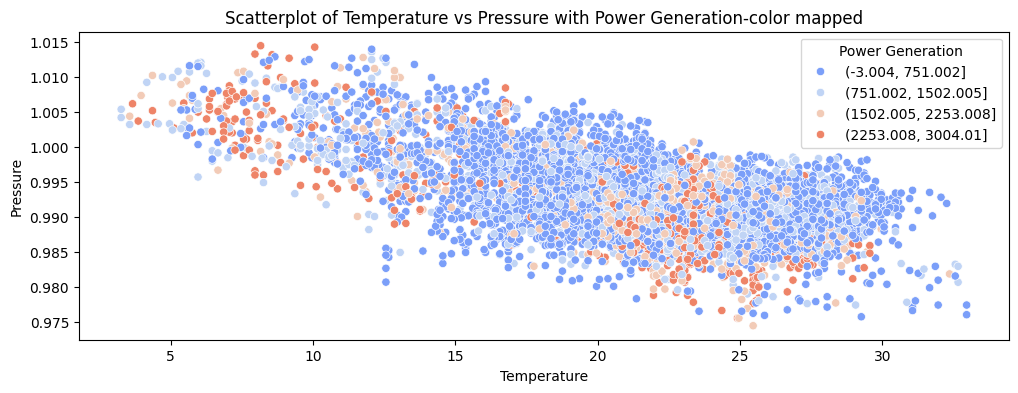

In [39]:
##creating bins of power generated values
num_bins = 4
data["binned_data"] = pd.cut(data["power_generated"], bins = num_bins) # Assign the binned data to a new column in the DataFrame

#creating figure and specifying size
plt.figure(figsize = (12,4))
sns.scatterplot(data = data, x = "temperature", y = "Pressure", hue = "binned_data", palette = "coolwarm") # Use palette instead of map

# adding title, legend, xlabel and ylabel
plt.title("Scatterplot of Temperature vs Pressure with Power Generation-color mapped")
plt.xlabel("Temperature")
plt.ylabel("Pressure")
plt.legend(title = "Power Generation", loc = "upper right")
plt.show()

<Axes: xlabel='season', ylabel='power_generated'>

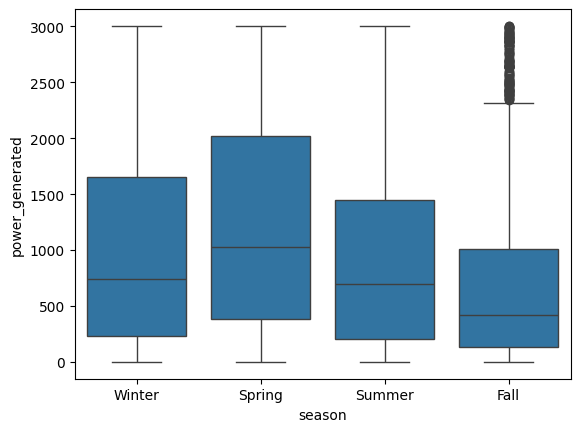

In [40]:
# observe the effect of season on power generation
sns.boxplot(data = data, x = "season", y = "power_generated")


spring is the most productive season for power generation and fall behind

<Axes: xlabel='season', ylabel='power_generated'>

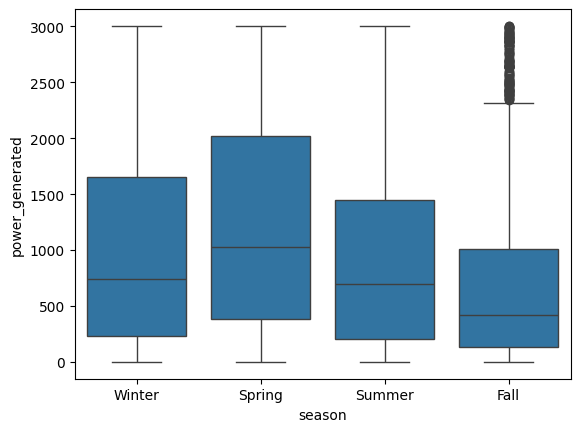

In [41]:
# wind characteristics
# wind characteristics
# wind speed and power generated

sns.boxplot(data = data, x = "season", y = "power_generated")

<Axes: xlabel='month', ylabel='power_generated'>

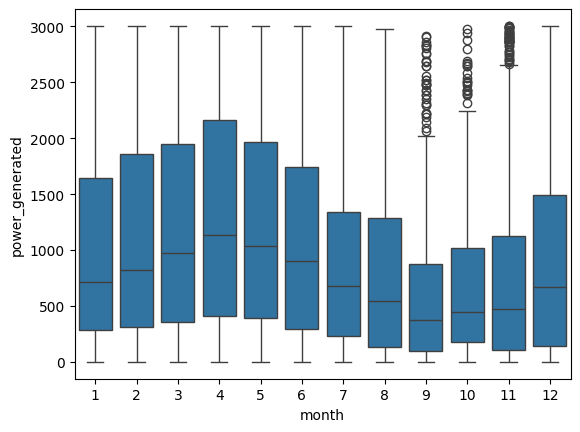

In [42]:
# wind speed and power generated
sns.boxplot(data = data, x = "month", y = "power_generated")

cyclical pattern emerges when you compare power generated vs month

In [43]:
data.columns

Index(['power_generated', 'Wind speed', 'Wind dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season', 'binned_data'],
      dtype='object')

<Axes: xlabel='month', ylabel='Wind speed'>

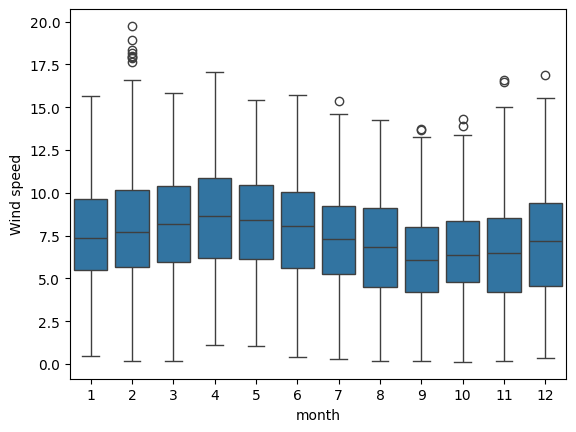

In [44]:
# month and power generated
sns.boxplot(data = data, x = "month", y = "Wind speed")

pattern same for wind speed vs month

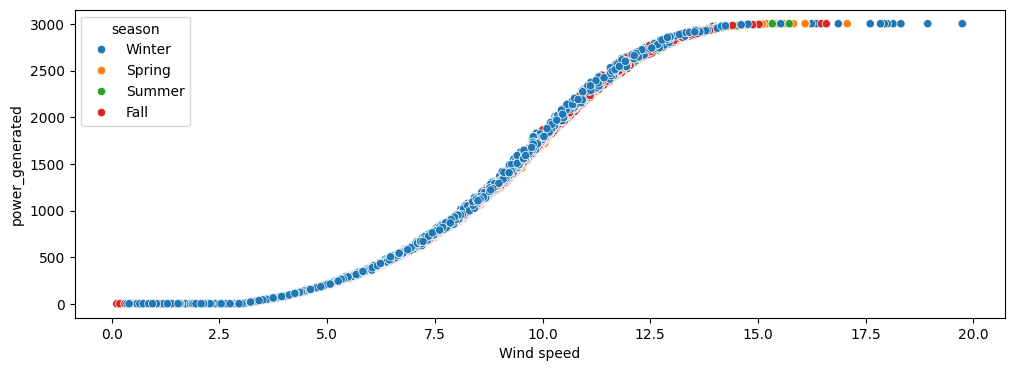

In [45]:
##scatterplot for wind speed vs power generated
plt.figure(figsize = (12,4))
sns.scatterplot(data = data, x = "Wind speed", y = "power_generated", hue = "season")
plt.show()

power generation curve

wind speed less than 2.5 do not lead to power generation

In [46]:
data.columns

Index(['power_generated', 'Wind speed', 'Wind dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season', 'binned_data'],
      dtype='object')

In [47]:
data.rename(columns={"Wind dir": "wind_dir"}, inplace=True)

In [48]:
data["wind_dir"]

bin_labels = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]

bin_edge = [-1, 45,90,135,180,225,270,315,360]

binned_data = pd.cut(data["wind_dir"], bins = bin_edge, labels = bin_labels)

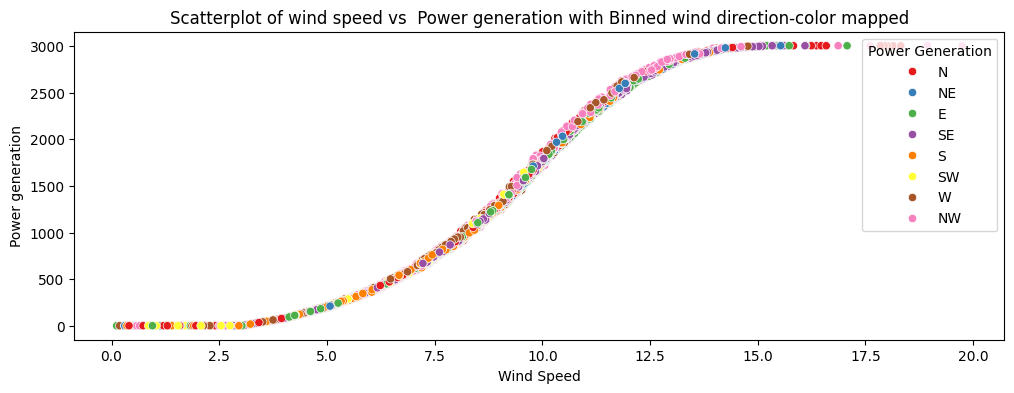

In [49]:
plt.figure(figsize = (12,4))
sns.scatterplot(data = data, x = "Wind speed", y = "power_generated", hue = binned_data , palette = "Set1")
plt.title("Scatterplot of wind speed vs  Power generation with Binned wind direction-color mapped")
plt.xlabel("Wind Speed")
plt.ylabel("Power generation")
plt.legend(title = "Power Generation", loc = "upper right")
plt.show()

<Axes: xlabel='wind_dir', ylabel='power_generated'>

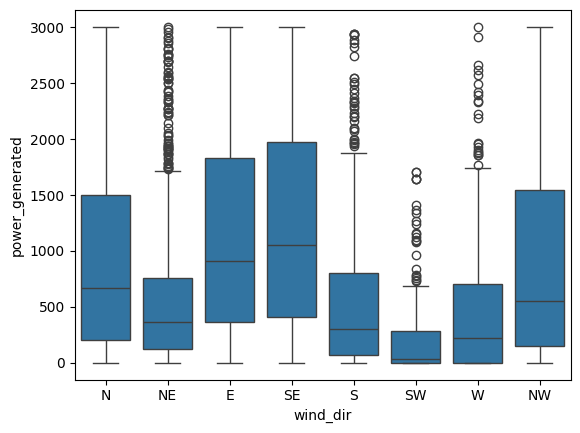

In [50]:
sns.boxplot(y = data["power_generated"], x = binned_data)

wind direction also influence power generated values

In [51]:
## quickly add the wind oreination features
data["wind_direction"] = binned_data

In [89]:
data.head()

,power_generated,Wind speed,wind_dir,Pressure,temperature,quarter,month,week,hour,season,binned_data,wind_speed_bin,wind_speed,wind_direction
Time stamp,,,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter,"(1502.005, 2253.008]","(5.025, 9.931]","(7.969, 9.931]",E
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter,"(751.002, 1502.005]","(5.025, 9.931]","(7.969, 9.931]",E
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter,"(751.002, 1502.005]","(5.025, 9.931]","(7.969, 9.931]",SE
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter,"(1502.005, 2253.008]","(5.025, 9.931]","(7.969, 9.931]",SE
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter,"(751.002, 1502.005]","(5.025, 9.931]","(7.969, 9.931]",SE


**MEAN ENCODING & MODELING**

In [60]:
len(data) * 0.3

2628.0

In [61]:
train_data = data[:-2628]
test_data = data[-2628:]

In [62]:
train_data

,power_generated,Wind speed,wind_dir,Pressure,temperature,quarter,month,week,hour,season,binned_data,wind_direction,binned_data_encoded
Time stamp,,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter,"(1502.005, 2253.008]",E,1
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter,"(751.002, 1502.005]",E,3
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter,"(751.002, 1502.005]",SE,3
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter,"(1502.005, 2253.008]",SE,1
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter,"(751.002, 1502.005]",SE,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 07:00:00,0.00,1.513,239,0.993169,26.863,3,9,37,7,Fall,"(-3.004, 751.002]",SW,0
2021-09-13 08:00:00,0.00,1.770,276,0.991688,27.563,3,9,37,8,Fall,"(-3.004, 751.002]",W,0
2021-09-13 09:00:00,0.00,1.977,328,0.992971,29.063,3,9,37,9,Fall,"(-3.004, 751.002]",NW,0


In [63]:
## perform mean encoding for season
season_mean = train_data.groupby("season")["power_generated"].mean()
data["season_mean_encoded"] = data["season"].map(season_mean)

In [64]:
data.columns

Index(['power_generated', 'Wind speed', 'wind_dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'season', 'binned_data',
       'wind_direction', 'binned_data_encoded', 'season_mean_encoded'],
      dtype='object')

In [65]:
## perform mean encoding for wind oreintation
wind_mean = train_data.groupby("wind_direction")["power_generated"].mean()
data["wind_direction_mean_encoded"] = data["wind_direction"].map(wind_mean)

In [66]:
data

,power_generated,Wind speed,wind_dir,Pressure,temperature,quarter,month,week,hour,season,binned_data,wind_direction,binned_data_encoded,season_mean_encoded,wind_direction_mean_encoded
Time stamp,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,Winter,"(1502.005, 2253.008]",E,1,1058.753692,1214.650349
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,Winter,"(751.002, 1502.005]",E,3,1058.753692,1214.650349
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,Winter,"(751.002, 1502.005]",SE,3,1058.753692,1248.372613
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,Winter,"(1502.005, 2253.008]",SE,1,1058.753692,1248.372613
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,Winter,"(751.002, 1502.005]",SE,3,1058.753692,1248.372613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,1234.70,8.848,129,0.998604,19.663,4,12,52,19,Winter,"(751.002, 1502.005]",E,3,1058.753692,1214.650349
2021-12-31 20:00:00,1105.37,8.502,118,1.000090,19.063,4,12,52,20,Winter,"(751.002, 1502.005]",E,3,1058.753692,1214.650349
2021-12-31 21:00:00,1405.71,9.224,117,0.998408,18.463,4,12,52,21,Winter,"(751.002, 1502.005]",E,3,1058.753692,1214.650349


In [67]:
data.drop(["season", "wind_direction"], axis = 1 , inplace = True)

In [68]:
train_data = data[:-2628]
test_data = data[-2628:]

In [69]:
train_data

,power_generated,Wind speed,wind_dir,Pressure,temperature,quarter,month,week,hour,binned_data,binned_data_encoded,season_mean_encoded,wind_direction_mean_encoded
Time stamp,,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,1,1,53,0,"(1502.005, 2253.008]",1,1058.753692,1214.650349
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,1,1,53,1,"(751.002, 1502.005]",3,1058.753692,1214.650349
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,1,1,53,2,"(751.002, 1502.005]",3,1058.753692,1248.372613
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,1,1,53,3,"(1502.005, 2253.008]",1,1058.753692,1248.372613
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,1,1,53,4,"(751.002, 1502.005]",3,1058.753692,1248.372613
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 07:00:00,0.00,1.513,239,0.993169,26.863,3,9,37,7,"(-3.004, 751.002]",0,867.021622,250.053972
2021-09-13 08:00:00,0.00,1.770,276,0.991688,27.563,3,9,37,8,"(-3.004, 751.002]",0,867.021622,489.797900
2021-09-13 09:00:00,0.00,1.977,328,0.992971,29.063,3,9,37,9,"(-3.004, 751.002]",0,867.021622,855.516311


In [104]:
###modelling


## linear models


## support vector machines: svr

## ensemble : rf, gbr

In [70]:
#imports
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [71]:
from sklearn.preprocessing import LabelEncoder  # Import the encoder

encoder = LabelEncoder()  # Create an instance of the encoder
train_data['binned_data_encoded'] = encoder.fit_transform(train_data['binned_data'])

In [72]:
train_data['binned_data_encoded'] = encoder.fit_transform(train_data['binned_data'])

In [73]:

train_data['binned_data_encoded'] = encoder.fit_transform(train_data['binned_data'])
test_data['binned_data_encoded'] = encoder.transform(test_data['binned_data']) # Use transform, not fit_transform for test data

In [74]:
data.columns

Index(['power_generated', 'Wind speed', 'wind_dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'binned_data',
       'binned_data_encoded', 'season_mean_encoded',
       'wind_direction_mean_encoded'],
      dtype='object')

In [76]:
target = "power_generated"
# Remove 'binned_data' from features and use 'binned_data_encoded' instead
#Also removed the columns not present in the dataframe and renamed 'Wind speed' to 'wind_speed'
features = ['power_generated', 'Wind speed', 'wind_dir', 'Pressure', 'temperature',
       'quarter', 'month', 'week', 'hour', 'binned_data_encoded', # Use the encoded column
        'season_mean_encoded', 'wind_direction_mean_encoded']
x_train = train_data[features]
y_train = train_data[target]
# Apply same changes for test data
x_test = test_data[features] # Use 'features' for consistency
y_test = test_data[target]

In [77]:
#linear regression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [78]:
# Random Forest regression
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

RandomForestRegressor()

In [79]:
# support vector machine
svr_model = SVR()
svr_model.fit(x_train, y_train)

SVR()

In [80]:
# Gradient boosting regression
gbr_model = GradientBoostingRegressor()
gbr_model.fit(x_train, y_train)

GradientBoostingRegressor()

In [81]:
# making prediction with model
lr_pred = lr_model.predict(x_test)
rf_pred = rf_model.predict(x_test)
svr_pred = svr_model.predict(x_test)
gbr_pred = gbr_model.predict(x_test)

In [82]:
# after predicting on test set, evaluating using mse
lr_mse = mean_squared_error(y_test, lr_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
svr_mse = mean_squared_error(y_test, svr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)

In [83]:
print("Linear Regression MSE:", lr_mse)
print("Random Forest MSE:", rf_mse)
print("Support Vector Machine MSE:", svr_mse)
print("Gradient Boosting MSE:", gbr_mse)

Linear Regression MSE: 1.7846240992159722e-24
Random Forest MSE: 0.17720522877613967
Support Vector Machine MSE: 33605.45708470905
Gradient Boosting MSE: 30.928066993135594


In [84]:
# after predicting on test set, evaluating using mse
lr_mae = mean_absolute_error(y_test, lr_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
gbr_mae = mean_absolute_error(y_test, gbr_pred)


In [85]:
print("Linear Regression MAE:", lr_mae)
print("Random Forest MAE:", rf_mae)
print("Support Vector Machine MAE:", svr_mae)
print("Gradient Boosting MAE:", gbr_mae)

Linear Regression MAE: 1.188593876370902e-12
Random Forest MAE: 0.26601782327245654
Support Vector Machine MAE: 115.70413842210405
Gradient Boosting MAE: 3.900822580763098


In [87]:
y_test.mean()

739.5319913727169

In [88]:
# rf and gb were off by roughly 0.6 percent

5/739 * 100

0.6765899864682002

**HYPER PARAMETER TUNING ON GRADIENT BOOSTING REGRESSOR AND RANDOM FOREST**

In [89]:
# Space/set of hyperparameters==> optimal values for each hyperparameter

# create a space
#objective ==> sample from this space, create a random forest model, evaluate the model, loss/mse
#minimize the objective: fmin

In [93]:
# Assuming 'features' is the list of feature column names from your previous code
X_train = train_data[features]  # Create X_train using the feature columns from train_data
X_val = X_train[-1200:]
y_val = y_train[-1200:]

X_train = X_train[:-1200]
y_train = y_train[:-1200]

In [90]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [99]:
## creating a space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300,1),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'max_features': hp.choice('max_features',["sqrt", "log2", None]) # Change 'min_features' to 'max_features'
}

In [98]:
## creating a space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300,1),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_features': hp.choice('max_features',["sqrt", "log2", None])
}

In [96]:
#objective ==> sample from this space, create a random forest model, evaluate the model, loss/mse
def objective(params):
  n_estimators = int(params["n_estimators"]) # Use params instead of space
  max_depth = int(params["max_depth"])       # Use params instead of space
  max_features = params["max_features"]      # Use params instead of space

  rf_model = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features,random_state = 42)

  rf_model.fit(X_train, y_train)

  y_pred = rf_model.predict(X_val)

  mse = mean_squared_error(y_val, y_pred)

  return {"loss": mse, "status": STATUS_OK}

In [100]:
# minimize the objectives : fmin
trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials,verbose= 1)

100%|██████████| 50/50 [03:32<00:00,  4.24s/trial, best loss: 0.3084505735022961]


In [101]:
print("Best Hyperparameters:", best)

Best Hyperparameters: {'max_depth': 20.0, 'max_features': 2, 'n_estimators': 123.0}


In [107]:
best_rf_hyperparameters = {'max_depth': 20.0, 'max_features': 2, 'n_estimators': 123.0}

In [102]:
## creating a space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300,1),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'learning_rate': hp.loguniform("learning_rate", -5, 0),
    "subsample": hp.uniform("subsample", 0.1 , 1)
}


In [103]:
#objective ==> sample from this space, create a random forest model, evaluate the model, loss/mse
def objective(params):
  n_estimators = int(params["n_estimators"]) # Use params instead of space
  max_depth = int(params["max_depth"])       # Use params instead of space
  max_features = params["max_features"]      # Use params instead of space

  gbr_model = GradientBoostingRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate= param["learning_rate"], subsample = params ["subsample"],random_state = 42)

  gbr_model.fit(X_train, y_train)

  y_pred = gbr_model.predict(X_val)

  mse = mean_squared_error(y_val, y_pred)

  return {"loss": mse, "status": STATUS_OK}

  y_pred = rf_model.predict(X_val)

  mse = mean_squared_error(y_val, y_pred)

  return {"loss": mse, "status": STATUS_OK}

In [105]:
## creating a space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300,1),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'learning_rate': hp.loguniform("learning_rate", -5, 0),
    "subsample": hp.uniform("subsample", 0.1 , 1),
    'max_features': hp.choice('max_features',["sqrt", "log2", None]) #add max_features to space
}

#objective ==> sample from this space, create a random forest model, evaluate the model, loss/mse
def objective(params):
  n_estimators = int(params["n_estimators"]) # Use params instead of space
  max_depth = int(params["max_depth"])       # Use params instead of space
  learning_rate = params["learning_rate"]      # Access learning_rate from params
  subsample = params["subsample"]
  max_features = params["max_features"]      # Use params instead of space # Access max_features from params



  gbr_model = GradientBoostingRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate= learning_rate, subsample = subsample,random_state = 42) # Pass learning_rate and subsample


  gbr_model.fit(X_train, y_train)

  y_pred = gbr_model.predict(X_val)

  mse = mean_squared_error(y_val, y_pred)

  return {"loss": mse, "status": STATUS_OK}

In [106]:
# minimize the objective: fmin
trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials,verbose= 1)

100%|██████████| 50/50 [05:14<00:00,  6.29s/trial, best loss: 0.21220578177468974]


In [108]:
print("Best Hyperparameters:", best)

Best Hyperparameters: {'learning_rate': 0.032961941809971265, 'max_depth': 15.0, 'max_features': 0, 'n_estimators': 279.0, 'subsample': 0.6228489093189793}


In [109]:
best_gbr_hyperparameters = {'learning_rate': 0.032961941809971265, 'max_depth': 15.0, 'max_features': 0, 'n_estimators': 279.0, 'subsample': 0.6228489093189793}

In [110]:
train_data = data[:-2628]
test_data = data[-2628:]

In [111]:
x_train = train_data[features]
y_train = train_data[target]
# Apply same changes for test data
x_test = test_data[features] # Use 'features' for consistency
y_test = test_data[target]

In [112]:
best_rf_hyperparameters

{'max_depth': 20.0, 'max_features': 2, 'n_estimators': 123.0}

In [114]:
rf_model = RandomForestRegressor(n_estimators = 123, max_depth = 20, max_features = 2, random_state=42)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print("MSE", rf_mse)
print("MAE", rf_mae)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print("MSE", rf_mse)
print("MAE", rf_mae)

MSE 5700.231828400669
MAE 49.77138636084356
MSE 5700.231828400669
MAE 49.77138636084356


In [116]:
best_gbr_hyperparameters

{'learning_rate': 0.032961941809971265,
 'max_depth': 15.0,
 'max_features': 0,
 'n_estimators': 279.0,
 'subsample': 0.6228489093189793}

In [120]:
gbr_model = GradientBoostingRegressor(n_estimators=281, max_depth=15,random_state=42,learning_rate=best_gbr_hyperparameters["learning_rate"], subsample=best_gbr_hyperparameters["subsample"])
gbr_model.fit(x_train, y_train)
gbr_pred = gbr_model.predict(x_test)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_mae = mean_absolute_error(y_test, gbr_pred)

print("MSE", gbr_mse)
print("MAE", gbr_mae)
gbr_mse = mean_squared_error(y_test, rf_pred)
gbr_mae = mean_absolute_error(y_test, rf_pred)

print("MSE", gbr_mse)
print("MAE", gbr_mae)

MSE 0.11117743621799167
MAE 0.21720021373555226
MSE 5700.231828400669
MAE 49.77138636084356


** BEST PERFORMING MODEL: GRADIENT BOOSTING REGRESSOR USING THE BEST HYPERPARAMETER

**Inference Script Creation**

In [128]:
import pandas as pd

data = pd.read_csv("/content/TexasTurbine.csv")
features = data.sample(5)

# Get the original column names from 'data'
original_columns = data.columns.tolist()

# Assign the original column names to 'features'
features.columns = original_columns

In [129]:
features

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
1363,"Feb 26, 07:00 pm",2738.1900,12.625,155,0.988732,20.663
6295,"Sep 20, 07:00 am",88.3827,4.113,53,0.988532,24.263
2617,"Apr 20, 01:00 am",1213.2200,8.818,127,0.992089,20.263
6024,"Sep 9, 12:00 am",1157.1200,8.739,163,0.990998,26.863
3650,"Jun 2, 02:00 am",2086.7100,10.766,160,0.988235,26.063


In [ ]:
def fix_timesstamp(data):
  data["timestamp"] = pd.to_datetime(data["timestamp"])


In [134]:
!mkdir model # create a directory to store pkl files if it doesn't exist.
import joblib
import os

# Saving the necessary encoders and data to files:
def save_model_artifacts(season_mean, wind_mean, encoder):
    """Saves model artifacts like encoders and mean values."""
    os.makedirs("model", exist_ok=True)  # Create 'model' directory if it doesn't exist
    joblib.dump(season_mean, "model/season_mean.pkl")
    joblib.dump(wind_mean, "model/wind_mean.pkl")
    joblib.dump(encoder, "model/encoder.pkl")

# After calculating season_mean, wind_mean, and fitting the encoder
save_model_artifacts(season_mean, wind_mean, encoder)

# ... [rest of your preprocess_data function] ...